# Chronos - Basic Usage

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from chronos import Chronos

import chronos_plotting

In [24]:
x = np.array(range(365*4))
my_df = pd.DataFrame({"ds": pd.date_range(start="2016-01-01", periods=365*4, freq='d'),
                      "y": 0.01 * x + np.sin(x/30)})
print(my_df.head())

          ds         y
0 2016-01-01  0.000000
1 2016-01-02  0.043327
2 2016-01-03  0.086617
3 2016-01-04  0.129833
4 2016-01-05  0.172939


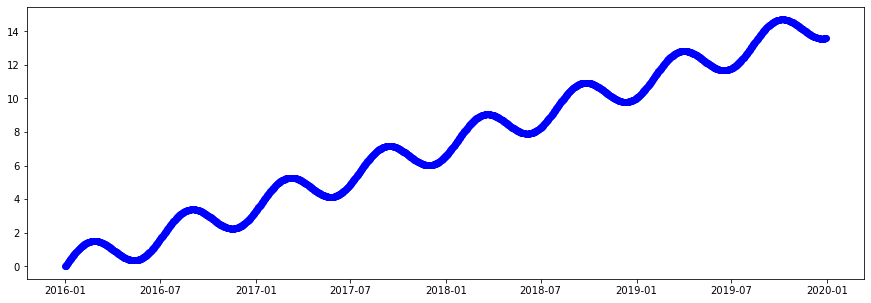

In [25]:
plt.figure(figsize=(15,5))
plt.scatter(my_df['ds'], my_df['y'], c="blue")
plt.show()

In [26]:
z = my_df.index.values
dummy1 = 0.01 * z
dummy2 = np.sin(z/30)
my_df['dummy1'] = dummy1
my_df['dummy2'] = dummy2
my_df.head()

,ds,y,dummy1,dummy2
0,2016-01-01,0.000000,0.00,0.000000
1,2016-01-02,0.043327,0.01,0.033327
2,2016-01-03,0.086617,0.02,0.066617
3,2016-01-04,0.129833,0.03,0.099833
4,2016-01-05,0.172939,0.04,0.132939


In [39]:
my_chronos = Chronos(max_iter=1000, learning_rate=0.001, distribution='Gamma')
my_chronos.add_regressors(regressor_name="dummy1", regressor_method="add")
my_chronos.add_regressors(regressor_name="dummy2", regressor_method="add")


In [40]:
my_chronos.fit(my_df)

Employing Maximum A Posteriori
100.0% - ELBO loss: -4.0162 | Mean Absolute Error: 0.0249                                           


In [41]:
future_df = my_chronos.make_future_dataframe(period=365)
z = future_df.index.values
dummy1 = 0.01 * z
dummy2 = np.sin(z/30)
future_df['dummy1'] = dummy1
future_df['dummy2'] = dummy2

future_df.tail()

,ds,y,dummy1,dummy2
1820,2020-12-25,NaN,18.20,-0.828490
1821,2020-12-26,NaN,18.21,-0.846693
1822,2020-12-27,NaN,18.22,-0.863956
1823,2020-12-28,NaN,18.23,-0.880258
1824,2020-12-29,NaN,18.24,-0.895583


In [42]:
predictions = my_chronos.predict(future_df, sample_number=1000)#, period=31)

/anaconda3/envs/pyroenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


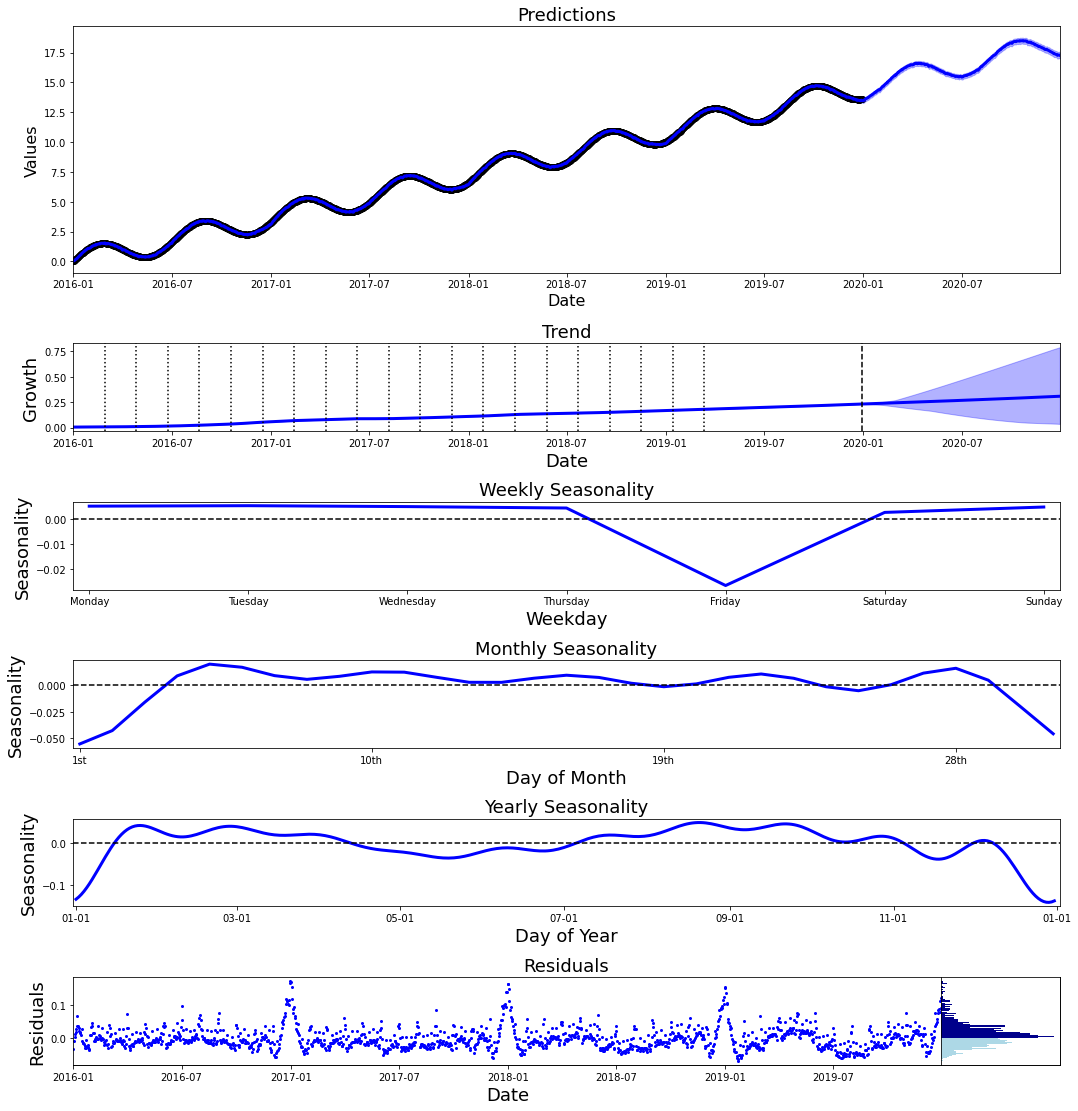

In [43]:
chronos_plotting.plot_components(predictions, my_chronos);

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

In [ ]:
my_ts_data = pd.read_csv('data/prophetData.csv')
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data.head()

In [ ]:
my_ts_data.shape

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("LOG(page_views)", size=16)
plt.title(f"LOG(page view) for Peyton Manning from 2007-2016", size=20)
plt.savefig("Time Series v1 t-distribution.png", dpi=96*4)
plt.show()

In [ ]:
from chronos import Chronos
import chronos_plotting

In [ ]:
my_chronos = Chronos(method="MAP", 
                     max_iter=1000, 
                     learning_rate=0.001,
                     distribution="Normal", 
                     seasonality_mode="add")
my_chronos.add_regressors("dummy", regressor_method="add")
my_ts_data["dummy"] = my_ts_data["y"].copy()

my_chronos.fit(my_ts_data)

In [ ]:
future_df = my_chronos.make_future_dataframe(period=365*2)
future_df['dummy'] = future_df['dummy'].fillna(8.0)
future_df.tail()

In [ ]:
predictions = my_chronos.predict(future_df, sample_number=100)
predictions.head()

In [ ]:
chronos_plotting.plot_components(predictions, my_chronos);

In [ ]:
chronos_plotting.plot_components(predictions);

In [ ]:
#assert(False)

## Bike Sharing Data

Coming from Chicago: https://www.kaggle.com/yingwurenjian/chicago-divvy-bicycle-sharing-data?select=data.csv

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from chronos import Chronos
import chronos_plotting

In [ ]:
bike_data = pd.read_csv('data/data.csv')
bike_data.head()

In [ ]:
relevant_data = bike_data[['starttime', 'trip_id']]
relevant_data['starttime'] = pd.to_datetime(relevant_data['starttime'])
relevant_data

In [ ]:
relevant_data['date'] = relevant_data['starttime'].dt.date
relevant_data.head()

In [ ]:
grouped_data = relevant_data.groupby('date').sum().reset_index()
grouped_data.columns = ['ds', 'y']
grouped_data['ds'] = pd.to_datetime(grouped_data['ds'])
grouped_data.head()

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(grouped_data['ds'], grouped_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("Trips", size=16)
plt.title(f"Trip Number Taken from Chicago's Divvy Bike Sharing Program", size=20)
plt.show()

In [ ]:
my_chronos = Chronos(method="MAP", max_iter=2000, 
                     learning_rate=0.01, 
                     n_changepoints=25,
                     changepoint_range=0.8,
                     changepoint_prior_scale=0.1,
                     distribution="Gamma",
                     seasonality_mode="mul")
my_chronos.fit(grouped_data)

In [ ]:
predictions = my_chronos.predict(sample_number=1000, frequency='D', ci_interval=0.95, period=365)

In [ ]:
chronos_plotting.plot_components(predictions, 
                                 my_chronos, 
                                 changepoint_threshold=0.0, 
                                 figure_name="Divvy components.png");

In [ ]:
fig = plt.figure(tight_layout=True, figsize=(15,5))
gs = gridspec.GridSpec(1, 1)
chronos_plotting.plot_predictions(predictions, fig=fig, gs_section=gs[0, :])
plt.title("Divvy Bike Sharing Modeled Using a Gamma Distribution", size=18)
plt.show();

In [ ]:
my_chronos = Chronos(method="MAP", max_iter=2000, 
                     learning_rate=0.1, 
                     n_changepoints=25,
                     changepoint_range=0.9,
                     changepoint_prior_scale=0.1,
                     distribution="Normal",
                     seasonality_mode="mul")
my_chronos.fit(grouped_data)

In [ ]:
predictions = my_chronos.predict(sample_number=1000, frequency='B', ci_interval=0.95, period=365)

In [ ]:
fig = plt.figure(tight_layout=True, figsize=(15,5))
gs = gridspec.GridSpec(1, 1)
chronos_plotting.plot_predictions(predictions, fig=fig, gs_section=gs[0, :])
plt.title("Divvy Bike Sharing Modeled Using a Normal Distribution", size=18)
plt.show();

## COVID

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from chronos import Chronos

In [ ]:
covid_data = pd.read_csv('data/covid19-download.csv')
covid_data.head(2)

In [ ]:
#canada_mask = covid_data['prname'] == 'British Columbia'
canada_mask = covid_data['prname'] == 'Ontario'
desired_columns = ['date', 'numtoday']

canada_daily_covid = covid_data[desired_columns].loc[canada_mask]
canada_daily_covid.head()

In [ ]:
canada_daily_covid.rename({'date': 'ds', 'numtoday': 'y'}, axis=1, inplace=True)
canada_daily_covid['ds'] = pd.to_datetime(canada_daily_covid['ds'])
#canada_daily_covid['y'] /= canada_daily_covid['y'].max()
canada_daily_covid = canada_daily_covid[canada_daily_covid['y']> 0]
canada_daily_covid.head()


In [ ]:
canada_daily_covid['y']

In [ ]:
canada_daily_covid['ds'].dt.day_name().isin(["Sunday", "Saturday"]).sum()/canada_daily_covid['ds'].shape[0]

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(canada_daily_covid['ds'], canada_daily_covid['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("Cases", size=16)
plt.title(f"Case Numbers for COVID-19 in Canada", size=20)
plt.show()

In [ ]:
my_chronos = Chronos(method="MAP", max_iter=2000, 
                     learning_rate=0.001, 
                     n_changepoints=25,
                     changepoint_range=0.9,
                     changepoint_prior_scale=10.0,
                     distribution="Gamma",
                     seasonality_mode="mul",
                     year_seasonality_order=0,
                     weekly_seasonality_order=6,
                     month_seasonality_order=0)#, weekly_seasonality_order=0, month_seasonality_order=0)
my_chronos.fit(canada_daily_covid)

In [ ]:
predictions = my_chronos.predict(sample_number=1000, frequency='B', ci_interval=0.95, period=60)

In [ ]:
chronos_plotting.plot_components(predictions, my_chronos, changepoint_threshold=0.0, figure_name="COVID components.png");

## AAPL stocks

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from chronos import Chronos
import chronos_plotting

In [17]:
my_ts_data = pd.read_csv('data/ETH-USD.csv')
my_ts_data = my_ts_data[['Date', 'Adj Close']]
my_ts_data.columns = ['ds', 'y']
#my_ts_data['y'] = 100*my_ts_data['y'].pct_change()
#my_ts_data['y'] = np.log(my_ts_data['y']+1)
my_ts_data.dropna(inplace=True)
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data = my_ts_data.iloc[:-7]
my_ts_data.head()

,ds,y
0,2016-01-15,1.20801
1,2016-01-16,1.22029
2,2016-01-17,1.32747
3,2016-01-18,1.42634
4,2016-01-19,1.37139


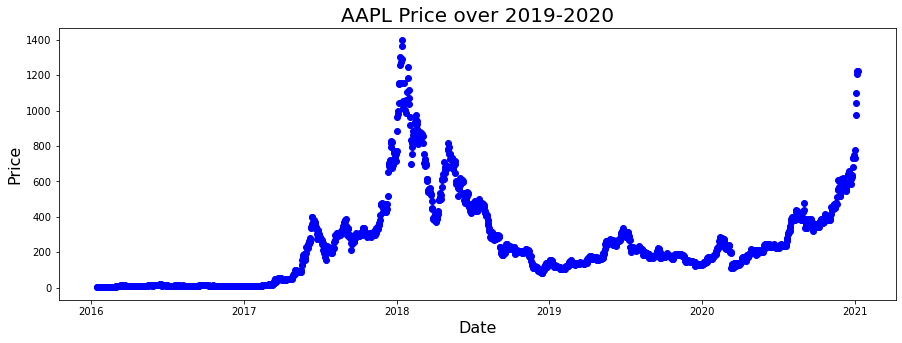

In [18]:
plt.figure(figsize=(15,5))
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("Price", size=16)
plt.title(f"AAPL Price over 2019-2020", size=20)
plt.show()

In [19]:
my_chronos = Chronos(method="MAP", max_iter=2000, 
                     learning_rate=0.1, 
                     n_changepoints=25,
                     changepoint_range=0.95,
                     changepoint_prior_scale=500.0,
                     seasonality_mode="mul",
                     distribution="Gamma",
                     year_seasonality_order=5)
my_chronos.fit(my_ts_data)

Employing Maximum A Posteriori
100.0% - ELBO loss: -2.3668 | Mean Absolute Error: 30.1227                                          


In [20]:
future_df = my_chronos.make_future_dataframe(period=31, frequency='D')
future_df

,ds,y
0,2016-01-15,1.20801
1,2016-01-16,1.22029
2,2016-01-17,1.32747
3,2016-01-18,1.42634
4,2016-01-19,1.37139
...,...,...
1847,2021-02-04,NaN
1848,2021-02-05,NaN
1849,2021-02-06,NaN
1850,2021-02-07,NaN


In [21]:
predictions = my_chronos.predict(future_df, sample_number=1000, ci_interval=0.99)
predictions.head()

,ds,y,yhat,yhat_upper,yhat_lower,trend,trend_upper,trend_lower
0,2016-01-15,1.20801,9.640912,41.720951,0.255693,0.001164,0.001164,0.001164
1,2016-01-16,1.22029,9.732801,38.849640,0.258422,0.001170,0.001170,0.001170
2,2016-01-17,1.32747,9.598393,37.261654,0.286511,0.001176,0.001176,0.001176
3,2016-01-18,1.42634,9.455355,41.109051,0.227236,0.001181,0.001181,0.001181
4,2016-01-19,1.37139,9.256671,38.776356,0.241782,0.001187,0.001187,0.001187


/Users/borisbshabash/Documents/new_repos/Chronos/chronos_plotting.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(figure_name, dpi=96*4)#'''
/anaconda3/envs/pyroenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


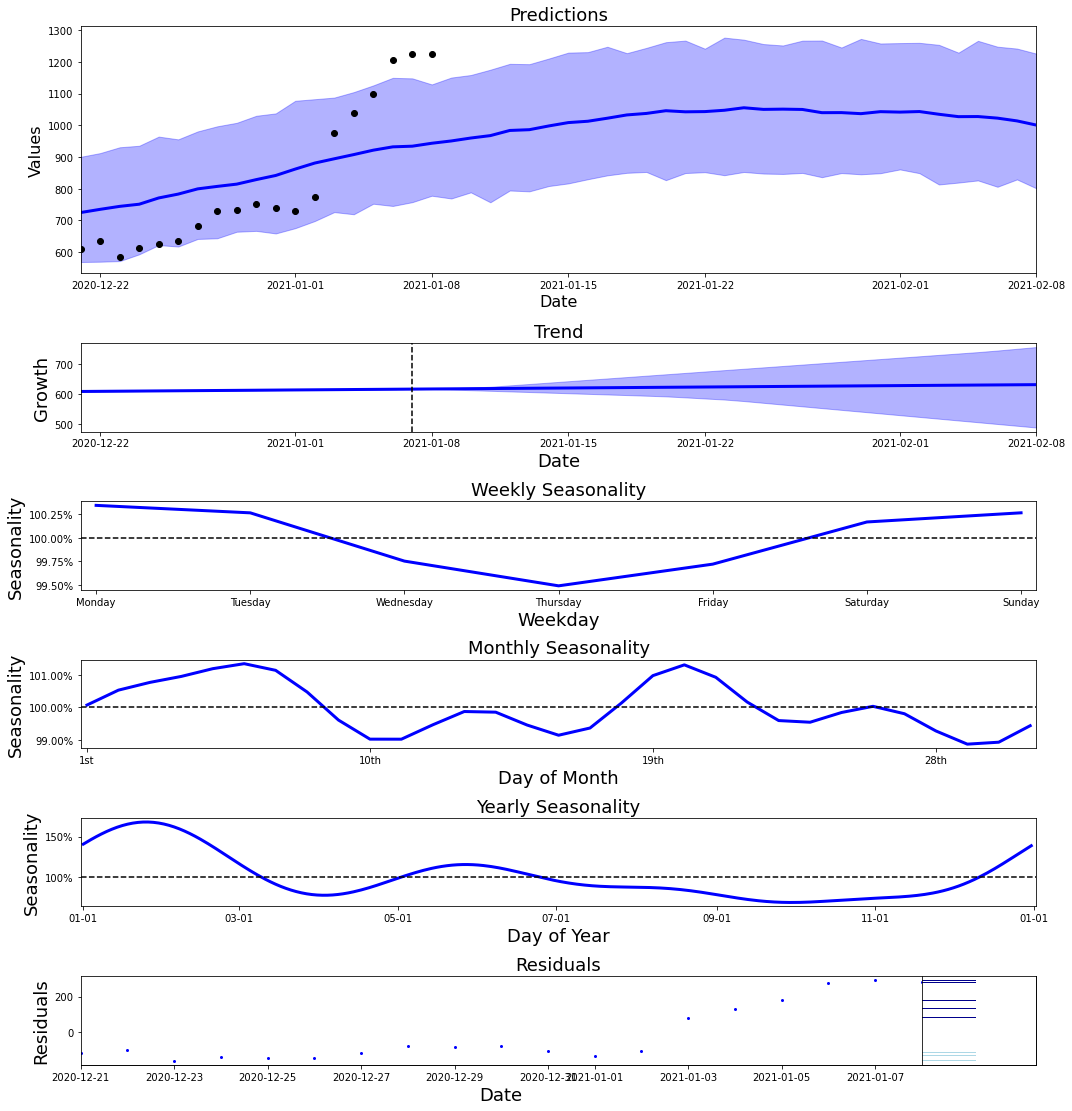

In [22]:
chronos_plotting.plot_components(predictions.iloc[-50:], my_chronos, figure_name="ETH.png", changepoint_threshold=0.3);